# Genetic Algorithm Workshop

In this workshop we will code up a genetic algorithm for a simple mathematical optimization problem.

Genetic Algorithm is a
* Meta-heuristic
* Inspired by Natural Selection
* Traditionally works on binary data. Can be adopted for other data types as well.

You can find an example illustrating GA below
![](https://github.com/timm/sbse14/wiki/etc/img/ga.jpg)

In [41]:
%matplotlib inline
# All the imports
from __future__ import print_function, division
from math import *
import random
import sys
import matplotlib.pyplot as plt

# TODO 1: Enter your unity ID here 
__author__ = "<ssharm24>"

class O:
    """
    Basic Class which
        - Helps dynamic updates
        - Pretty Prints
    """
    def __init__(self, **kwargs):
        self.has().update(**kwargs)
    def has(self):
        return self.__dict__
    def update(self, **kwargs):
        self.has().update(kwargs)
        return self
    def __repr__(self):
        show = [':%s %s' % (k, self.has()[k]) 
                for k in sorted(self.has().keys()) 
                if k[0] is not "_"]
        txt = ' '.join(show)
        if len(txt) > 60:
            show = map(lambda x: '\t' + x + '\n', show)
        return '{' + ' '.join(show) + '}'
    
print("Unity ID: ", __author__)

Unity ID:  <ssharm24>


### The optimization problem
The problem we are considering is a mathematical one 
<img src="cone.png" width=500px/>

**Decisions**: *r* in [0, 10] cm; *h* in [0, 20] cm

**Objectives**: minimize *S*, *T*

**Constraints**: *V* > 200cm<sup>3</sup>

In [42]:
# Few Utility functions
def say(lst):
    """
    Print whithout going to new line
    """
    print(lst, end="")
    sys.stdout.flush()

def random_value(low, high, decimals=2):
    """
    Generate a random number between low and high. 
    decimals incidicate number of decimal places
    """
    return round(random.uniform(low, high),decimals)

def gt(a, b): return a > b

def lt(a, b): return a < b

def shuffle(lst):
    """
    Shuffle a list
    """
    random.shuffle(lst)
    return lst

class Decision(O):
    """
    Class indicating Decision of a problem
    """
    def __init__(self, name, low, high):
        """
        @param name: Name of the decision
        @param low: minimum value
        @param high: maximum value
        """
        O.__init__(self, name=name, low=low, high=high)
        
class Objective(O):
    """
    Class indicating Objective of a problem
    """
    def __init__(self, name, do_minimize=True):
        """
        @param name: Name of the objective
        @param do_minimize: Flag indicating if objective has to be minimized or maximized
        """
        O.__init__(self, name=name, do_minimize=do_minimize)

class Point(O):
    """
    Represents a member of the population
    """
    def __init__(self, decisions):
        O.__init__(self)
        self.decisions = decisions
        self.objectives = None
        
    def __hash__(self):
        return hash(tuple(self.decisions))
    
    def __eq__(self, other):
        return self.decisions == other.decisions
    
    def clone(self):
        new = Point(self.decisions)
        new.objectives = self.objectives
        return new

class Problem(O):
    """
    Class representing the cone problem.
    """
    def __init__(self):
        O.__init__(self)
        # TODO 2: Code up decisions and objectives below for the problem
        ht = Decision("height",0,20)
        rd = Decision("radius",0,10)
        csa = Objective("Curved Surface area")
        tsa = Objective("Total Surface area")
        # using the auxilary classes provided above.
        self.decisions = [rd,ht]
        self.objectives = [csa,tsa]
        
    @staticmethod
    def evaluate(point):
        [r, h] = point.decisions
        point.objectives = None
        # TODO 3: Evaluate the objectives S and T for the point.
        area1 = pi*(r**2)
        area2 = area1 + pi*r*(((r**2) + (h**2))**0.5)
        point.objectives = [area1,area2]
        return point.objectives
    
    @staticmethod
    def is_valid(point):
        [r, h] = point.decisions
        # TODO 4: Check if the point has valid decisions
        valid = pi*(r**2)*h/3
        return valid>200
    
    def generate_one(self):
        # TODO 5: Generate a valid instance of Point.
        point = Point([random_value(d.low,d.high) for d in self.decisions])
        while(not Problem.is_valid(point)):
            point=Point([random_value(d.low,d.high) for d in self.decisions])
        return point

cone = Problem()
point = cone.generate_one()
cone.evaluate(point)
print(point)


{	:decisions [7.88, 19.61]
 	:objectives [195.07531086906604, 718.2636523126392]
}


Great. Now that the class and its basic methods is defined, we move on to code up the GA.
### Population
First up is to create an initial population. 

In [43]:
def populate(problem, size):
    # TODO 6: Create a list of points of length 'size'
    return [problem.generate_one() for x in range(size)]
        
p=populate(cone, 5)
print(p)

[{:decisions [9.48, 12.09] :objectives None}, {:decisions [5.4, 11.78] :objectives None}, {:decisions [8.6, 14.33] :objectives None}, {:decisions [6.03, 10.29] :objectives None}, {:decisions [4.99, 8.68] :objectives None}]


### Crossover
We perform a single point crossover between two points

In [44]:
def crossover(mom, dad):
    # TODO 7: Create a new point which contains decisions from 
    # the first half of mom and second half of dad
    dec = [mom.decisions[0], dad.decisions[1]]
    return Point(dec)

#p = populate(cone,5)
#print("Mom:{}, Dad:{}".format(p[0],p[1]))
child = crossover(p[0],p[1])
print(child)

{:decisions [9.48, 11.78] :objectives None}


### Mutation
Randomly change a decision such that 

In [45]:
def mutate(problem, point, mutation_rate=0.01):
    # TODO 8: Iterate through all the decisions in the point
    # and if the probability is less than mutation rate
    # change the decision(randomly set it between its max and min).
    for i in xrange(0,len(problem.decisions)):
        if random.random()<mutation_rate:
            print(point.decisions)
            point.decisions[i]=random_value(problem.decisions[i].low,problem.decisions[i].high)
    return point
print(mutate(cone,child))

{:decisions [9.48, 11.78] :objectives None}


### Fitness Evaluation
To evaluate fitness between points we use binary domination. Binary Domination is defined as follows:
* Consider two points one and two.
* For every decision **o** and **t** in **one** and **two**, **o** <= **t**
* Atleast one decision **o** and **t** in **one** and **two**, **o** == **t**

**Note**: Binary Domination is not the best method to evaluate fitness but due to its simplicity we choose to use it for this workshop.


In [46]:
def bdom(problem, one, two):
    """
    Return if one dominates two
    """
    objs_one = problem.evaluate(one)
    objs_two = problem.evaluate(two)
    # TODO 9: Return True/False based on the definition
    # of bdom above.
    eq = False
    for i in range(len(objs_one)):
        for j in range(len(objs_one)):
            if not objs_one[i]<=objs_two[j]:
                return False
            if(objs_one[i]==objs_two[j]):
                eq = True
    return eq

print("Dominates:",bdom(cone,p[0],p[1]))

Dominates: False


### Fitness and Elitism

In this workshop we will count the number of points of the population P dominated by a point A as the fitness of point A. This is a very naive measure of fitness since we are using binary domination. 

Few prominent alternate methods are
1. [Continuous Domination](http://www.tik.ee.ethz.ch/sop/publicationListFiles/zk2004a.pdf) - Section 3.1
2. [Non-dominated Sort](http://ieeexplore.ieee.org/stamp/stamp.jsp?arnumber=996017)
3. [Non-dominated Sort + Niching](http://www.egr.msu.edu/~kdeb/papers/k2012009.pdf)

**Elitism**: Sort points with respect to the fitness and select the top points.

In [47]:
def fitness(problem, population, point):
    dominates = 0
    # TODO 10: Evaluate fitness of a point.
    # For this workshop define fitness of a point 
    # as the number of points dominated by it.
    # For example point dominates 5 members of population,
    # then fitness of point is 5.
    for point2 in population:
        if(bdom(problem,point,point2)):
            dominates+=1
    return dominates

def elitism(problem, population, retain_size):
    # TODO 11: Sort the population with respect to the fitness
    # of the points and return the top 'retain_size' points of the population
    pop_fit = [(x,fitness(problem,population,x)) for x in population]
    population = [x for x,y in sorted(pop_fit, key=lambda x:x[1])]
    return population[:retain_size]
print(elitism(cone,p,10))

[{	:decisions [9.48, 12.09]
 	:objectives [282.33618841517614, 739.8978549046666]
}, {	:decisions [5.4, 11.78]
 	:objectives [91.60884177867838, 311.4483316244342]
}, {	:decisions [8.6, 14.33]
 	:objectives [232.35219265950107, 683.8864561103553]
}, {	:decisions [6.03, 10.29]
 	:objectives [114.23113631791311, 340.1672684370775]
}, {	:decisions [4.99, 8.68]
 	:objectives [78.22597123365121, 235.1814076889371]
}]


### Putting it all together and making the GA

In [48]:
def ga(pop_size = 100, gens = 250):
    problem = Problem()
    population = populate(problem, pop_size)
    [problem.evaluate(point) for point in population]
    initial_population = [point.clone() for point in population]
    gen = 0 
    while gen < gens:
        say(".")
        children = []
        for _ in range(pop_size):
            mom = random.choice(population)
            dad = random.choice(population)
            while (mom == dad):
                dad = random.choice(population)
            child = mutate(problem, crossover(mom, dad))
            if problem.is_valid(child) and child not in population+children:
                children.append(child)
        population += children
        population = elitism(problem, population, pop_size)
        gen += 1
    print("")
    return initial_population, population

### Visualize
Lets plot the initial population with respect to the final frontier.

In [49]:
def plot_pareto(initial, final):
    initial_objs = [point.objectives for point in initial]
    final_objs = [point.objectives for point in final]
    initial_x = [i[0] for i in initial_objs]
    initial_y = [i[1] for i in initial_objs]
    final_x = [i[0] for i in final_objs]
    final_y = [i[1] for i in final_objs]
    plt.scatter(initial_x, initial_y, color='b', marker='+', label='initial')
    plt.scatter(final_x, final_y, color='r', marker='o', label='final')
    plt.title("Scatter Plot between initial and final population of GA")
    plt.ylabel("Total Surface Area(T)")
    plt.xlabel("Curved Surface Area(S)")
    plt.legend(loc=9, bbox_to_anchor=(0.5, -0.175), ncol=2)
    plt.show()
    

.[6.1, 12.76]
[4.91, 5.31]
[5.92, 15.42]
.[9.7, 19.06]
[4.76, 14.14]
[6.84, 15.85]
[3.86, 14.14]
[6.33, 3.28]
.[8.53, 8.75]
[3.98, 11.04]
.[5.52, 16.29]
[7.82, 11.63]
[7.16, 6.56]
.[4.91, 18.7]
[3.86, 12.15]
.[8.3, 18.52]
[5.51, 16.77]
.[9.94, 16.31]
[6.32, 13.36]
.[5.77, 14.99]
[9.26, 14.99]
[6.59, 19.06]
.[9.46, 19.34]
[4.51, 10.99]
[6.2, 7.22]
[4.25, 11.33]
[6.31, 11.04]
.[9.35, 15.86]
[5.92, 12.73]
.[9.7, 5.79]
[6.59, 6.12]
[6.55, 18.52]
.[8.86, 13.44]
[7.36, 16.28]
[6.32, 19.06]
[7.39, 16.28]
[7.44, 7.29]
[8.12, 10.9]
.[7.36, 11.77]
[5.51, 6.56]
.[7.27, 13.37]
[4.91, 5.76]
[4.25, 14.94]
.[6.89, 5.17]
[7.25, 5.79]
[7.39, 6.57]
.[8.08, 12.73]
[7.82, 7.65]
[6.39, 7.22]
.[9.94, 14.94]
.[9.35, 7.34]
[7.03, 7.87]
[9.94, 11.94]
..[5.22, 8.69]
[6.83, 15.42]
[6.58, 7.87]
.[3.9, 16.08]
[9.4, 12.6]
[7.44, 13.37]
.[8.5, 7.34]
.[9.57, 12.73]
[7.51, 12.89]
[8.53, 9.15]
[7.68, 14.14]
.[7.17, 12.6]
[8.55, 3.28]
[7.14, 6.56]
...[3.86, 11.94]
[8.3, 3.32]
[4.25, 9.68]
.[8.98, 11.57]
[7.16, 5.76]
[6.

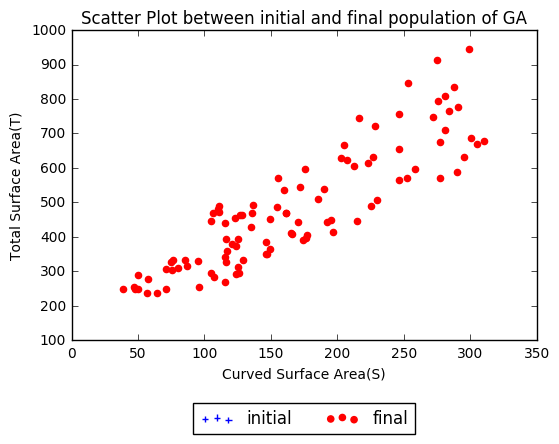

In [50]:
initial, final = ga()
plot_pareto(initial, final)

Here is a sample output
<img src="sample.png" width=300/>